# DiscreteDP Example: Option Pricing 

**Akihiro Sasaki**

*Department of Economics, University of Tokyo*

From Miranda and Fackler, Applied Computational Economics and Finance, 2002, Section7.6.4

Julia translation of the [python version](http://nbviewer.jupyter.org/github/QuantEcon/QuantEcon.notebooks/blob/master/ddp_ex_MF_7_6_4_py.ipynb)

In [1]:
using QuantEcon
using PyPlot

In [2]:
T = 0.5       # Time expiration (years)
vol = 0.2     # Annual volatility
r = 0.05      # Annual interest rate
strike = 2.1  # Strike price
p0 = 2        # Current price
N = 100      # Number of periods to expiration

# Time length of a period
tau = T/N

# Discount factor
beta = exp(-r*tau)

# Up-jump factor
u = exp(vol*sqrt(tau))

# Up-jump probability
q = 1/2 + sqrt(tau)*(r - (vol^2)/2)/(2*vol);

In [3]:
# Possible price values
ps = [u^i for i = -N:N] * p0

# Number of states
n = length(ps) + 1  # State n: "the option has been exercised"

# Number of actions
m = 2  # 0: hold, 1: exercise

# Number of feasible state-action pairs
L = n*m - 1;  # At state n, there is only one action "do nothing"

In [4]:
s_indices = Array{Int}(L+1)
a_indices = Array{Int}(L+1)

i = 1
for s  = 1:n
    for a  = 0:m-1
        s_indices[i] = s
        a_indices[i] = a
        i += 1
    end
end

In [5]:
# Arrays of state and action indices
s_indices, a_indices = s_indices[1:end-1], a_indices[1:end-1];

In [6]:
# Reward vector
R = zeros(m, n)
R[1, :] = 0
R[2,1:end-1] = strike - ps
R = vec(R)[1:end-1];

In [7]:
# Transition probability array
Q = zeros(L, n)
for i = 1:L-1
    if a_indices[i] == 0
        Q[i, min(s_indices[i]+1, length(ps))] = q
        Q[i, max(s_indices[i]-1, 1)] = 1 - q
    else
        Q[i, n] = 1
    end
end
Q[L, n] = 1;

In [8]:
# Create a DiscreteDP
ddp = DiscreteDP(R, Q, beta, s_indices, a_indices);

In [9]:
v = zeros(n)
sigma = Array{Float64}(n)
max_exercise_price = Array{Float64}(N)
for i = 1:N
    v, sigma = QuantEcon.bellman_operator!(ddp::DiscreteDP, v, sigma)
    max_exercise_price[i] = ps[Int(sum(sigma))]
end

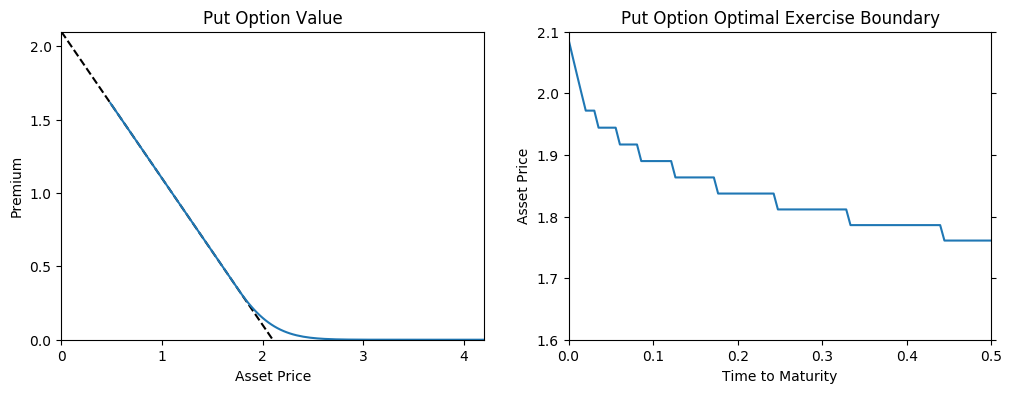

In [10]:
fig, axes = subplots(1, 2, figsize=(12, 4))


axes[1][:plot]([0, strike], [strike, 0], "k--")
axes[1][:plot](ps, v[1:n-1])
axes[1][:set_xlim](0, strike*2)
axes[1][:set_xticks](linspace(0, 4, 5))
axes[1][:set_ylim](0, strike)
axes[1][:set_yticks](linspace(0, 2, 5))
axes[1][:set_xlabel]("Asset Price")
axes[1][:set_ylabel]("Premium")
axes[1][:set_title]("Put Option Value")


axes[2][:plot](linspace(0, T, N), max_exercise_price)
axes[2][:set_xlim](0, T)
axes[2][:set_ylim](1.6, strike)
axes[2][:set_xlabel]("Time to Maturity")
axes[2][:set_ylabel]("Asset Price")
axes[2][:set_title]("Put Option Optimal Exercise Boundary")
axes[2][:tick_params](right="on")